In [1]:
import pathlib
import timeit

import ase.io
import matplotlib.pyplot as plt
import mdtraj
import numpy as np
import pandas as pd
import tqdm
from chemfiles import Frame, Trajectory

import znh5md

In [2]:
N_ATOMS = np.logspace(1, 3, 20, dtype=int)
N_STEPS = 1000
N_TRIALS = 5

In [3]:
H5MD_FILE = pathlib.Path("test.h5")
XYZ_FILE = pathlib.Path("test.xyz")
PDB_FILE = pathlib.Path("test.pdb")
XTC_FILE = pathlib.Path("test.xtc")

In [4]:
def create_topology(n_atoms):
    return mdtraj.Topology().from_dataframe(
        pd.DataFrame(
            {
                "serial": np.arange(n_atoms),
                "name": "C",
                "resSeq": 1,
                "resName": "UNK",
                "element": "C",
                "chainID": "A",
            }
        )
    )

In [5]:
znh5md_write_times = []
znh5md_read_times = []

ase_xyz_write_times = []
ase_xyz_read_times = []

chemfiles_pdb_write_times = []
chemfiles_pdb_read_times = []

mdtraj_xtc_read_times = []  # TODO: rename to XTC file
mdtraj_xtc_write_times = []

# TODO: mdanalysis, read H5MD
# TODO: mdanalysis, read/write PDB or XYZ or TRR
# TODO: file size comparison


def write_chemfiles_pdb(frames):
    with Trajectory(PDB_FILE.as_posix(), "w") as traj:
        for frame in frames:
            traj.write(frame)


def read_chemfiles_pdb():
    with Trajectory(PDB_FILE.as_posix(), "r") as traj:
        for frame in traj:
            # access to actually read the data?
            _ = frame.positions


def read_mdtraj_xtc(n_atoms):
    traj = mdtraj.load_xtc(XTC_FILE.as_posix(), top=create_topology(n_atoms))
    for frame in traj:
        # access to actually read the data?
        _ = frame.xyz


def writie_mdtraj_xtc(frames):
    traj = mdtraj.Trajectory(
        frames[0].positions[np.newaxis], create_topology(len(frames[0].positions))
    )
    for frame in frames[1:]:
        traj = traj.join(
            mdtraj.Trajectory(
                frame.positions[np.newaxis], create_topology(len(frame.positions))
            )
        )
    traj.save_xtc(XTC_FILE.as_posix())


tbar = tqdm.tqdm(total=len(N_ATOMS) * N_TRIALS)

for n_atoms in N_ATOMS:
    images = []
    frames = []
    for n in range(N_STEPS):
        atoms = ase.Atoms("H" * n_atoms, positions=np.random.rand(n_atoms, 3))
        images.append(atoms)
        frame = Frame()
        frame.resize(n_atoms)
        frame.positions[:] = atoms.positions
        frames.append(frame)
    for _ in range(N_TRIALS):
        tbar.update(1)
        tbar.set_description(f"n_atoms={n_atoms}")
        if H5MD_FILE.exists():
            H5MD_FILE.unlink()
        if XYZ_FILE.exists():
            XYZ_FILE.unlink()
        if PDB_FILE.exists():
            PDB_FILE.unlink()
        if XTC_FILE.exists():
            XTC_FILE.unlink()
        znh5md_write_times.append(
            timeit.timeit(lambda: znh5md.write(H5MD_FILE, images), number=1)
        )
        znh5md_read_times.append(
            timeit.timeit(
                lambda: znh5md.read(H5MD_FILE, index=slice(None, None, None)), number=1
            )
        )

        ase_xyz_write_times.append(
            timeit.timeit(
                lambda: ase.io.write(XYZ_FILE, images, format="xyz"), number=1
            )
        )
        ase_xyz_read_times.append(
            timeit.timeit(
                lambda: ase.io.read(XYZ_FILE, index=slice(None, None, None)), number=1
            )
        )

        mdtraj_xtc_write_times.append(
            timeit.timeit(lambda: writie_mdtraj_xtc(frames), number=1)
        )

        chemfiles_pdb_write_times.append(
            timeit.timeit(lambda: write_chemfiles_pdb(frames), number=1)
        )

        chemfiles_pdb_read_times.append(
            timeit.timeit(lambda: read_chemfiles_pdb(), number=1)
        )

        mdtraj_xtc_read_times.append(
            timeit.timeit(lambda: read_mdtraj_xtc(n_atoms=n_atoms), number=1)
        )

n_atoms=1000: 100%|██████████| 100/100 [08:03<00:00, 19.29s/it]

In [6]:
chemfiles_pdb_read_times = np.reshape(chemfiles_pdb_read_times, (-1, N_TRIALS))
chemfiles_pdb_write_times = np.reshape(chemfiles_pdb_write_times, (-1, N_TRIALS))
ase_xyz_read_times = np.reshape(ase_xyz_read_times, (-1, N_TRIALS))
ase_xyz_write_times = np.reshape(ase_xyz_write_times, (-1, N_TRIALS))
znh5md_read_times = np.reshape(znh5md_read_times, (-1, N_TRIALS))
znh5md_write_times = np.reshape(znh5md_write_times, (-1, N_TRIALS))
mdtraj_xtc_read_times = np.reshape(mdtraj_xtc_read_times, (-1, N_TRIALS))
mdtraj_xtc_write_times = np.reshape(mdtraj_xtc_write_times, (-1, N_TRIALS))

In [7]:
df = pd.DataFrame(
    {
        "znh5md:write": np.mean(znh5md_write_times, axis=1),
        "znh5md:read": np.mean(znh5md_read_times, axis=1),
        "ase:xyz:write": np.mean(ase_xyz_write_times, axis=1),
        "ase:xyz:read": np.mean(ase_xyz_read_times, axis=1),
        "chemfiles:pdb:write": np.mean(chemfiles_pdb_write_times, axis=1),
        "chemfiles:pdb:read": np.mean(chemfiles_pdb_read_times, axis=1),
        "mdtraj:xtc:read": np.mean(mdtraj_xtc_read_times, axis=1),
        "mdtraj:xtc:write": np.mean(mdtraj_xtc_write_times, axis=1),
    },
    index=N_ATOMS,
)

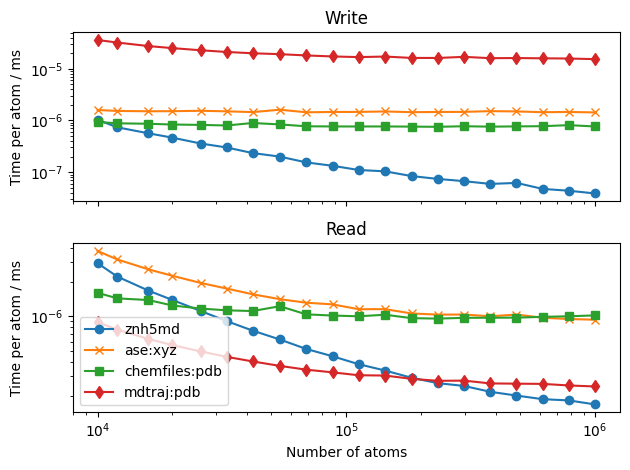

In [ ]:
# two figures, one for write and one for read.
# Both values should be divided by the index
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].set_title("Write")
axes[0].plot(
    df.index * N_STEPS,
    df["znh5md:write"] / df.index / N_STEPS,
    label="znh5md",
    marker="o",
)
axes[0].plot(
    df.index * N_STEPS,
    df["ase:xyz:write"] / df.index / N_STEPS,
    label="ase:xyz",
    marker="x",
)
axes[0].plot(
    df.index * N_STEPS,
    df["chemfiles:pdb:write"] / df.index / N_STEPS,
    label="chemfiles:pdb",
    marker="s",
)
axes[0].plot(
    df.index * N_STEPS,
    df["mdtraj:xtc:write"] / df.index / N_STEPS,
    label="mdtraj:xtc",
    marker="d",
)
# axes[0].legend()
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_ylabel("Time per atom / ms")
# axes[0].set_xlabel("Number of atoms")

axes[1].set_title("Read")
axes[1].plot(
    df.index * N_STEPS,
    df["znh5md:read"] / df.index / N_STEPS,
    label="znh5md",
    marker="o",
)
axes[1].plot(
    df.index * N_STEPS,
    df["ase:xyz:read"] / df.index / N_STEPS,
    label="ase:xyz",
    marker="x",
)
axes[1].plot(
    df.index * N_STEPS,
    df["chemfiles:pdb:read"] / df.index / N_STEPS,
    label="chemfiles:pdb",
    marker="s",
)
axes[1].plot(
    df.index * N_STEPS,
    df["mdtraj:xtc:read"] / df.index / N_STEPS,
    label="mdtraj:xtc",
    marker="d",
)
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_ylabel("Time per atom / ms")
axes[1].set_xlabel("Number of atoms")
axes[1].legend()
fig.tight_layout()
plt.savefig("benchmark.png")

In [ ]:
raise ValueError

In [11]:
H5MD_FILE.unlink()
XYZ_FILE.unlink()
PDB_FILE.unlink()
XTC_FILE.unlink()